# **SOM** - Linear map & Random initialization of weights

## Import libraries

In [1]:
import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot as plt
import time
from math import exp


## Load the dataset

In [2]:
iterations = 20

(_, _), (test_images, test_labels) = mnist.load_data()

reduced_mnist_images = [test_images[np.random.choice(a=np.where(test_labels == j)[0], size=100)] for j in range(10)]
reduced_mnist_images = np.array(reduced_mnist_images, dtype='float32') / 255

reduced_mnist_images = reduced_mnist_images.reshape((1000, 784))
reduced_mnist_labels = np.array([100*[i] for i in range(10)], dtype='int').flatten()

shuffled_indices = np.random.permutation(np.arange(1000))

reduced_mnist_images = reduced_mnist_images[shuffled_indices]
reduced_mnist_labels = reduced_mnist_labels[shuffled_indices]

## Implementation

In [3]:
def learning_rate_generator_with_decay():
   global iterations
   time = 0
   while True:
       yield (1 - (time/iterations))
       time += 1

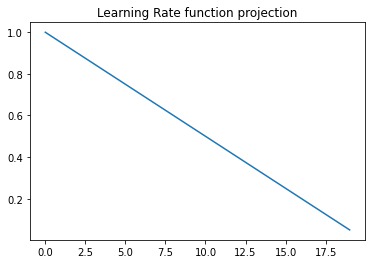

In [4]:
lr_list = []
lr_with_decay = learning_rate_generator_with_decay()
for i in range(iterations):
    lr_list.append(next(lr_with_decay))

plt.plot(list(range(iterations)),lr_list)
plt.title("Learning Rate function projection")
plt.show()

In [5]:
# Define and fill the weight matrix
# the dimensions are 784 (input size) by 625 (neurons/clusters)
som_weight_matrix = np.random.rand(784, 625) / 10

In [6]:
lr_with_decay = learning_rate_generator_with_decay()    # instantiate a lr generator

weights_snapshot = {0 : som_weight_matrix.copy()}   # snapshot for some epochs
coverage_history = np.zeros((iterations+1, 625), dtype=bool)

winning_counts = dict()
winning_classes_counts = dict()

for epoch in range(iterations):

    lr = next(lr_with_decay)    # Get new learning rate value

    start = time.time()     # start the timer

    for x in range(1000):    

        # Calculate Euclidean distance for all neurons
        distance_matrix = np.sqrt(((som_weight_matrix.transpose() - reduced_mnist_images[x])**2).sum(axis = 1))

        # Find index of minimum distance
        winner_unit = np.argmin(distance_matrix)
        coverage_history[epoch, winner_unit] = True

        # Update the neuron's weights
        dif = reduced_mnist_images[x] - som_weight_matrix[:, winner_unit]
        som_weight_matrix[:, winner_unit] += (dif * lr)
        
        # If it is the last epoch, we want to store the winning statistics of neurons
        if epoch + 1 == iterations:
            winning_counts[winner_unit] = winning_counts.get(winner_unit, 0) + 1
            winning_classes_counts[(winner_unit, reduced_mnist_labels[x])] = winning_classes_counts.get((winner_unit, reduced_mnist_labels[x]), 0) + 1
    
    end = time.time()
    print("epoch %d - %.3f s" % (epoch + 1, end - start))

    weights_snapshot[epoch + 1] = som_weight_matrix.copy()



epoch 1 - 1.396 s
epoch 2 - 1.400 s
epoch 3 - 1.429 s
epoch 4 - 1.275 s
epoch 5 - 1.307 s
epoch 6 - 1.321 s
epoch 7 - 1.332 s
epoch 8 - 1.406 s
epoch 9 - 1.577 s
epoch 10 - 1.621 s
epoch 11 - 1.542 s
epoch 12 - 1.544 s
epoch 13 - 1.563 s
epoch 14 - 1.560 s
epoch 15 - 1.548 s
epoch 16 - 1.567 s
epoch 17 - 1.556 s
epoch 18 - 1.571 s
epoch 19 - 1.562 s
epoch 20 - 1.575 s


### Show twenty neurons with the most winnings at the last epoch

In [7]:
twenty_neurons_with_most_winning = [k for k, v in sorted(winning_counts.items(), key=lambda item: item[1], reverse = True)][:20]

stat_table = np.zeros((20,10), dtype='int')

for i, neu in enumerate(twenty_neurons_with_most_winning):
    for class_label in range(0, 10):
        stat_table[i][class_label] = winning_classes_counts.get((neu, class_label), 0)

import pandas as pd 

df = pd.DataFrame(stat_table, index=twenty_neurons_with_most_winning, columns=['label {0}'.format(i) for i in range(0,10)])
df['Total'] = df.sum(axis=1)
print("Total sum:  %d images" % df['Total'].sum())
df

Total sum:  271 images


,label 0,label 1,label 2,label 3,label 4,label 5,label 6,label 7,label 8,label 9,Total
612,0,32,0,0,1,0,0,0,0,0,33
389,0,23,0,0,0,0,0,0,0,0,23
332,0,0,0,0,0,0,0,15,0,2,17
444,0,16,0,0,0,0,0,0,0,0,16
27,0,0,2,0,0,0,0,13,0,1,16
585,0,0,0,0,5,1,0,1,0,8,15
119,14,0,0,0,0,0,0,0,0,0,14
607,0,0,0,0,0,0,0,6,0,7,13
482,0,0,0,0,3,0,0,0,0,9,12
204,0,0,0,0,0,0,12,0,0,0,12


### Generate and save figures

In [8]:
import os
os.makedirs('./linear-topology_random-weights/', exist_ok=True)

In [9]:
for epoch, weight_mat in weights_snapshot.items():
    fig = plt.figure(figsize=(17,17))
    axes = [fig.add_subplot(25,25,i+1) for i in range(625)]

    for n, ax in enumerate(axes):
        ax.imshow(weight_mat[:,n].reshape((28,28)), cmap=("gray_r" if coverage_history[epoch, n] == False else "plasma"))

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if n >= 600: ax.set_xlabel(n%25 + 1)
        if n%25==0: ax.set_ylabel(n//25 + 1)
        ax.tick_params(axis='both', which='both', length=0)
        ax.label_outer

    fig.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle("Epoch %d - [Linear Topology , Random Weights initialization]" % epoch, fontsize=18)

    # write the figure for this epoch on disk
    path = f"./linear-topology_random-weights/epoch-{epoch}"
    fig.savefig(path)
    plt.close(fig)

    print(f"Saved: {path}.png")

Saved: ./linear-topology_random-weights/epoch-0.png
Saved: ./linear-topology_random-weights/epoch-1.png
Saved: ./linear-topology_random-weights/epoch-2.png
Saved: ./linear-topology_random-weights/epoch-3.png
Saved: ./linear-topology_random-weights/epoch-4.png
Saved: ./linear-topology_random-weights/epoch-5.png
Saved: ./linear-topology_random-weights/epoch-6.png
Saved: ./linear-topology_random-weights/epoch-7.png
Saved: ./linear-topology_random-weights/epoch-8.png
Saved: ./linear-topology_random-weights/epoch-9.png
Saved: ./linear-topology_random-weights/epoch-10.png
Saved: ./linear-topology_random-weights/epoch-11.png
Saved: ./linear-topology_random-weights/epoch-12.png
Saved: ./linear-topology_random-weights/epoch-13.png
Saved: ./linear-topology_random-weights/epoch-14.png
Saved: ./linear-topology_random-weights/epoch-15.png
Saved: ./linear-topology_random-weights/epoch-16.png
Saved: ./linear-topology_random-weights/epoch-17.png
Saved: ./linear-topology_random-weights/epoch-18.png
Sav

In [10]:
!zip -r linear_random.zip /content/linear-topology_random-weights

  adding: content/linear-topology_random-weights/ (stored 0%)
  adding: content/linear-topology_random-weights/epoch-20.png (deflated 13%)
  adding: content/linear-topology_random-weights/epoch-14.png (deflated 9%)
  adding: content/linear-topology_random-weights/epoch-13.png (deflated 9%)
  adding: content/linear-topology_random-weights/epoch-3.png (deflated 9%)
  adding: content/linear-topology_random-weights/epoch-5.png (deflated 9%)
  adding: content/linear-topology_random-weights/epoch-4.png (deflated 9%)
  adding: content/linear-topology_random-weights/epoch-10.png (deflated 9%)
  adding: content/linear-topology_random-weights/epoch-6.png (deflated 9%)
  adding: content/linear-topology_random-weights/epoch-2.png (deflated 9%)
  adding: content/linear-topology_random-weights/epoch-0.png (deflated 8%)
  adding: content/linear-topology_random-weights/epoch-18.png (deflated 9%)
  adding: content/linear-topology_random-weights/epoch-11.png (deflated 9%)
  adding: content/linear-topolo